<a href="https://colab.research.google.com/github/zSoftwareRepository/MDS556/blob/main/Statmodels_Logistic_Regression_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload

## This expands a notebook to full width
from IPython.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))
## Show Python Version
import sys
print("Python: {0}".format(sys.version))

## Show Current Time
import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

Python: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Notebook Last Run Initiated: 2022-11-20 14:20:44.719587


In [ ]:
# importing libraries

import warnings
warnings.filterwarnings("ignore")

seed = 23

import numpy as np
np.random.seed(seed)

import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [ ]:
features = ['ratio_open_30','prob_mix_ro_30t60','ratio_open_30t60','engaged_prob','engaged_index','avg_key_del_open','ratio_open_60','var_deliveries_last_60',
            'std_deliveries_last_90','prob_mix_ro_60t90','ratio_open_60t90','var_key_del_open','avg_deliveries_last_60','ratio_deliveries_last_60',
            'ratio_keydeliveries_last_60','ratio_deliveries_last_90','avg_deliveries_last_90','ratio_keydeliveries_last_90','avg_deliveries_last_180',
            'ratio_deliveries_last_180','std_key_del_close','ratio_keydeliveries_last_180','datediff_create_trans','datediff_month','ratio_open_90',
            'total_opens_last_90t180','app_ratio_open_90t180','app_total_opens_last_180','ratio_open_90t180','total_opens_last_180','app_total_opens_by_device',
            'age_1stperson_hushld','app_total_opens_last_90','avg_opens_by_device','std_opens_by_device','app_ratio_open_60t90','app_ratio_open_90',
            'app_ratio_open_60','app_total_opens_last_60','app_avg_opens_last_90','app_avg_opens_last_60','app_std_opens_last_60','app_ratio_open_30t60',
            'app_std_opens_last_30','app_avg_opens_last_30','app_ratio_open_30','app_total_opens_last_30','no_of_adults_hushld','home_lot_square_footage',
            'home_square_footage','vehicle_year_1st','home_loan_amount']

In [ ]:
def get_dummies(data,field,prefix):
    data[field] = data[field].fillna('na')
    dms = pd.get_dummies(data.loc[:,field], prefix=prefix)
    return pd.concat([data,dms],axis=1)

In [ ]:
def toLog10(df,feature):    
    df[feature].fillna(0, inplace=True)
    return np.log10(df[feature]+1)

In [ ]:
data = pd.read_csv('data/mydata.csv',low_memory=False)

In [ ]:
target = data[['target']]
target.columns=['target']

In [ ]:
data = data.replace(np.nan, 0)
data.home_loan_amount = data.home_loan_amount * -1

In [ ]:
#Create dummies for the gender feature
data = data[features + ['gender']]
data = get_dummies(data,'gender','gnd')
#data.filter(regex='^gnd',axis=1).head()

In [ ]:
#Binnarize and create dummies for the vehicle year feature
data['vehicle_year_bin'] = data['vehicle_year_1st'].apply(lambda x : 'new_model' if x >= 2019 else ('med_model' if (x < 2019 and x >= 2015) else 'old_model'))
data = get_dummies(data,'vehicle_year_bin','vyc')

In [ ]:
drop_features = ['gender','vehicle_year_1st','vehicle_year_bin']
data.drop(drop_features,inplace=True,axis=1)
print(data.shape)

(249575, 57)


In [ ]:
#Remove featrures that are correlated -/+0.8 to other features

corr = data.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if np.abs(corr.iloc[i,j]) >= 0.8:
            if columns[j]:
                columns[j] = False
                
selected_columns = data.columns[columns]
data = data[selected_columns].copy()
print(data.shape)                

(249575, 28)


In [ ]:
# Split data 80% for training 20% for test

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=seed)
saved_cols = X_train.columns
y_train = y_train.values.ravel()

In [ ]:
#Scale data

sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=saved_cols)
X_test  = pd.DataFrame(sc.fit_transform(X_test), columns=saved_cols)

In [ ]:
#Add Intersect

#X_train = sm.add_constant(X_train)
#X_test = sm.add_constant(X_test)

In [ ]:
# Execute logistic regression with regularization 'l1'

regressor_logit = sm.Logit(y_train, X_train).fit_regularized(method='l1',maxiter=500)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6768745224786609
            Iterations: 58
            Function evaluations: 59
            Gradient evaluations: 58


In [ ]:
# make predictions for test data and evaluate

predictions = regressor_logit.predict(X_test)
preds_4errors = predictions.copy()
predictions = np.round(predictions,0)
accuracy = accuracy_score(y_test.target, predictions)

In [ ]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1 Score: %.2f%%" % (f1_score(y_test.target, predictions) * 100.0))

Accuracy: 66.32%
F1 Score: 28.38%


In [ ]:
# confusion m,atrix
tn, fp, fn, tp = confusion_matrix(y_test.target, predictions).ravel()
print(tn, fp, fn, tp)

29773 15609 1202 3331


In [ ]:
sensitivity = tp/(tp+fn)
print("True Positive Rate: %.2f%%" % (sensitivity * 100.0))
specificity = tn/(tn+fp)
print("True Negative Rate: %.2f%%" % (specificity * 100.0))

True Positive Rate: 73.48%
True Negative Rate: 65.61%


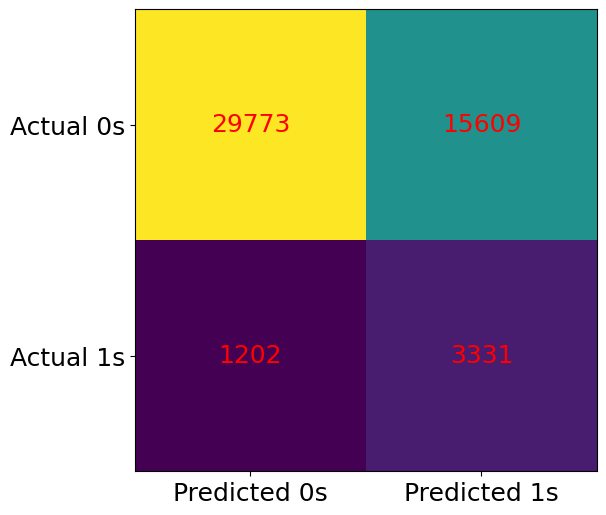

In [ ]:
cm = confusion_matrix(y_test, predictions)

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=18)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [ ]:
c1 = pd.DataFrame(data.columns.values.reshape(-1,1),columns=['features'])
c2 = pd.DataFrame(regressor_logit.params.values.reshape(-1,1),columns=['coefficients'])

coefficients = pd.concat([c1,c2],axis=1)
coefficients['exp'] = np.exp(coefficients.coefficients)

coefficients.to_csv('coefficients.csv',index=False)

In [ ]:
regressor_logit.params

ratio_open_30                 -0.015049
prob_mix_ro_30t60             -0.057098
engaged_prob                   0.169232
avg_key_del_open               0.098592
var_deliveries_last_60         0.109244
var_key_del_open               0.018569
avg_deliveries_last_60        -0.052600
ratio_keydeliveries_last_60    0.004836
std_key_del_close              0.015976
total_opens_last_90t180        0.108353
app_ratio_open_90t180          0.007111
app_total_opens_last_180      -0.036030
ratio_open_90t180              0.051513
age_1stperson_hushld           0.138780
avg_opens_by_device           -0.084176
std_opens_by_device            0.069491
app_ratio_open_60t90           0.006974
app_ratio_open_90             -0.048120
app_avg_opens_last_90         -0.010189
app_std_opens_last_60          0.031457
app_ratio_open_30t60           0.009838
home_lot_square_footage       -0.001117
home_square_footage           -0.003024
home_loan_amount               0.001760
gnd_F                         -0.056772


In [ ]:
regressor_logit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                 Logit               Pseudo R-squared:    -1.219     
Dependent Variable:    y                   AIC:                 270345.5343
Date:                  2022-11-20 14:20    BIC:                 270631.2567
No. Observations:      199660              Log-Likelihood:      -1.3514e+05
Df Model:              27                  LL-Null:             -60916.    
Df Residuals:          199632              LLR p-value:         1.0000     
Converged:             1.0000              Scale:               1.0000     
No. Iterations:        58.0000                                             
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
ratio_open_30               -0.0150   0.0076 -1.9914 0.0464 -0.0299 -0.0002
prob_mix_ro_30t60           -0.0571   0.0082 -6.9932 0.0000 -0.0731 -0.0411
engaged_prob                 0.1692   0.0070 24.1870 0.0000  0.1555  0.1829
avg_key_del_open             0.0986   0.0091 10.7837 0.0000  0.0807  0.1165
var_deliveries_last_60       0.1092   0.0070 15.6148 0.0000  0.0955  0.1230
var_key_del_open             0.0186   0.0089  2.0753 0.0380  0.0010  0.0361
avg_deliveries_last_60      -0.0526   0.0059 -8.9832 0.0000 -0.0641 -0.0411
ratio_keydeliveries_last_60  0.0048   0.0051  0.9491 0.3426 -0.0052  0.0148
std_key_del_close            0.0160   0.0085  1.8774 0.0605 -0.0007  0.0327
total_opens_last_90t180      0.1084   0.0172  6.3103 0.0000  0.0747  0.1420
app_ratio_open_90t180        0.0071   0.0053  1.3464 0.1782 -0.0032  0.0175
app_total_opens_last_180    -0.0360   0.0077 -4.6805 0.0000 -0.0511 -0.0209
ratio_open_90t180            0.0515   0.0066  7.8602 0.0000  0.0387  0.0644
age_1stperson_hushld         0.1388   0.0104 13.3097 0.0000  0.1183  0.1592
avg_opens_by_device         -0.0842   0.0155 -5.4288 0.0000 -0.1146 -0.0538
std_opens_by_device          0.0695   0.0090  7.7413 0.0000  0.0519  0.0871
app_ratio_open_60t90         0.0070   0.0069  1.0098 0.3126 -0.0066  0.0205
app_ratio_open_90           -0.0481   0.0130 -3.7031 0.0002 -0.0736 -0.0227
app_avg_opens_last_90       -0.0102   0.0089 -1.1430 0.2530 -0.0277  0.0073
app_std_opens_last_60        0.0315   0.0095  3.3026 0.0010  0.0128  0.0501
app_ratio_open_30t60         0.0098   0.0073  1.3470 0.1780 -0.0045  0.0242
home_lot_square_footage     -0.0011   0.0045 -0.2464 0.8054 -0.0100  0.0078
home_square_footage         -0.0030   0.0047 -0.6417 0.5210 -0.0123  0.0062
home_loan_amount             0.0018   0.0046  0.3859 0.6996 -0.0072  0.0107
gnd_F                       -0.0568   0.0079 -7.2074 0.0000 -0.0722 -0.0413
gnd_M                       -0.0336   0.0101 -3.3144 0.0009 -0.0535 -0.0137
vyc_med_model               -0.0089   0.0047 -1.9078 0.0564 -0.0181  0.0002
vyc_new_model               -0.0035   0.0046 -0.7548 0.4504 -0.0125  0.0055
===========================================================================

"""

In [ ]:
regressor_logit.pvalues

ratio_open_30                   4.643878e-02
prob_mix_ro_30t60               2.687257e-12
engaged_prob                   3.050027e-129
avg_key_del_open                4.110116e-27
var_deliveries_last_60          5.776135e-55
var_key_del_open                3.795755e-02
avg_deliveries_last_60          2.630319e-19
ratio_keydeliveries_last_60     3.425521e-01
std_key_del_close               6.046279e-02
total_opens_last_90t180         2.784670e-10
app_ratio_open_90t180           1.781868e-01
app_total_opens_last_180        2.861458e-06
ratio_open_90t180               3.835097e-15
age_1stperson_hushld            2.033983e-40
avg_opens_by_device             5.674174e-08
std_opens_by_device             9.838187e-15
app_ratio_open_60t90            3.125853e-01
app_ratio_open_90               2.129486e-04
app_avg_opens_last_90           2.530252e-01
app_std_opens_last_60           9.577973e-04
app_ratio_open_30t60            1.779656e-01
home_lot_square_footage         8.053619e-01
home_squar

In [ ]:
residuals = pd.DataFrame({'actual': y_test.target.values.flatten(), 'predicted': preds_4errors, 'residual': (y_test.target.values - preds_4errors)})

In [ ]:
plt.rc("figure", figsize=(8, 4))
plt.rc("font", size=8)

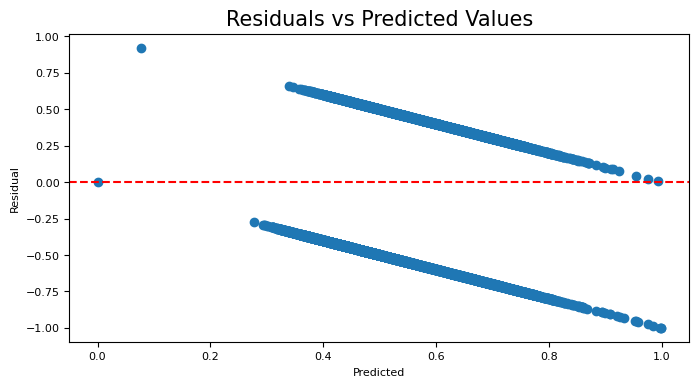

In [ ]:
plt.scatter(residuals.predicted,residuals.residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted Values', size=15)
plt.axhline(y=0, color="red", linestyle="--")
plt.show()

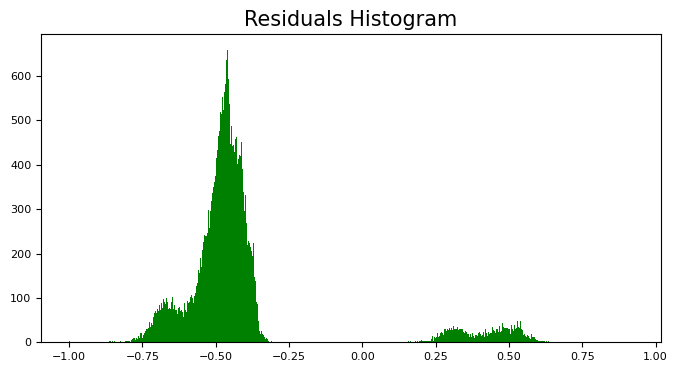

In [ ]:
plt.title('Residuals Histogram', size=15)
_ = plt.hist(residuals.residual, bins=1000, color = 'green')
plt.show()

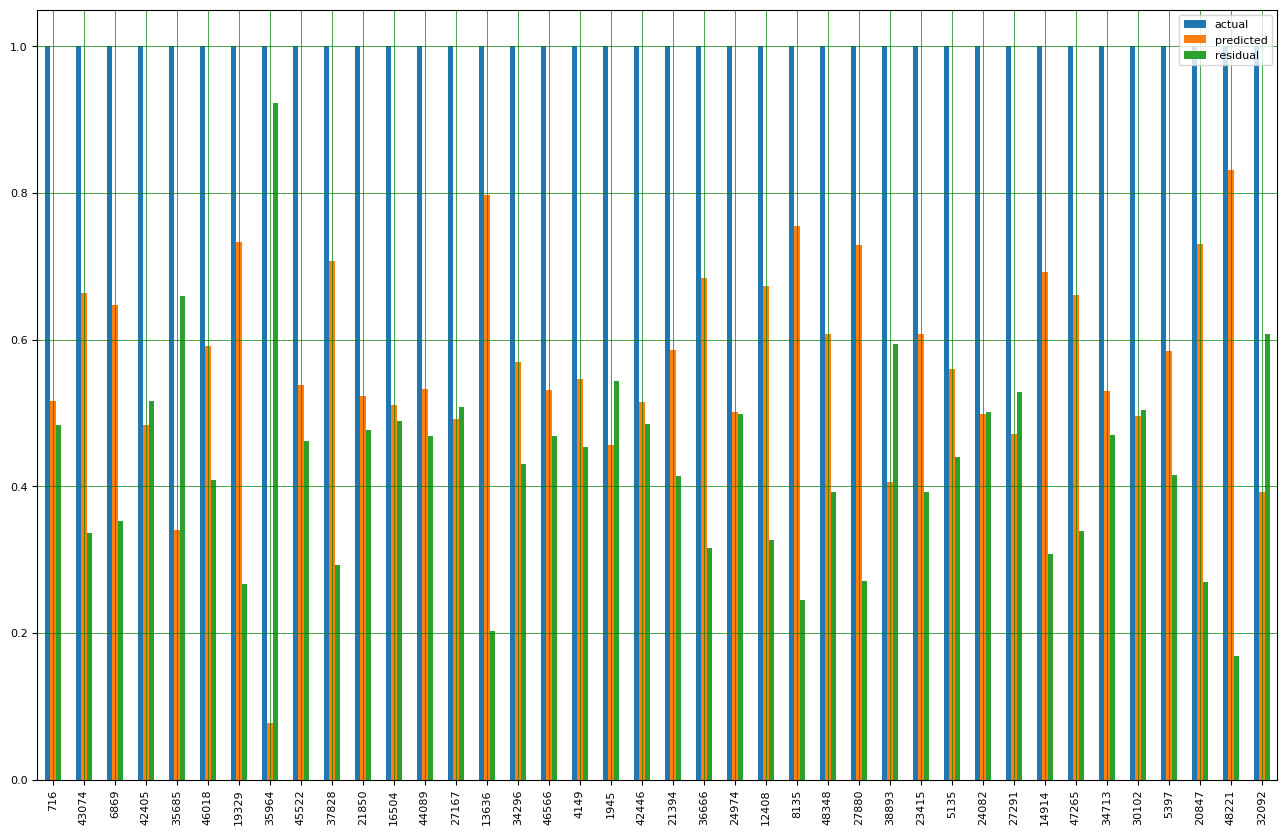

In [ ]:
df1m = residuals[residuals.actual == 1].sample(40)
df1m.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

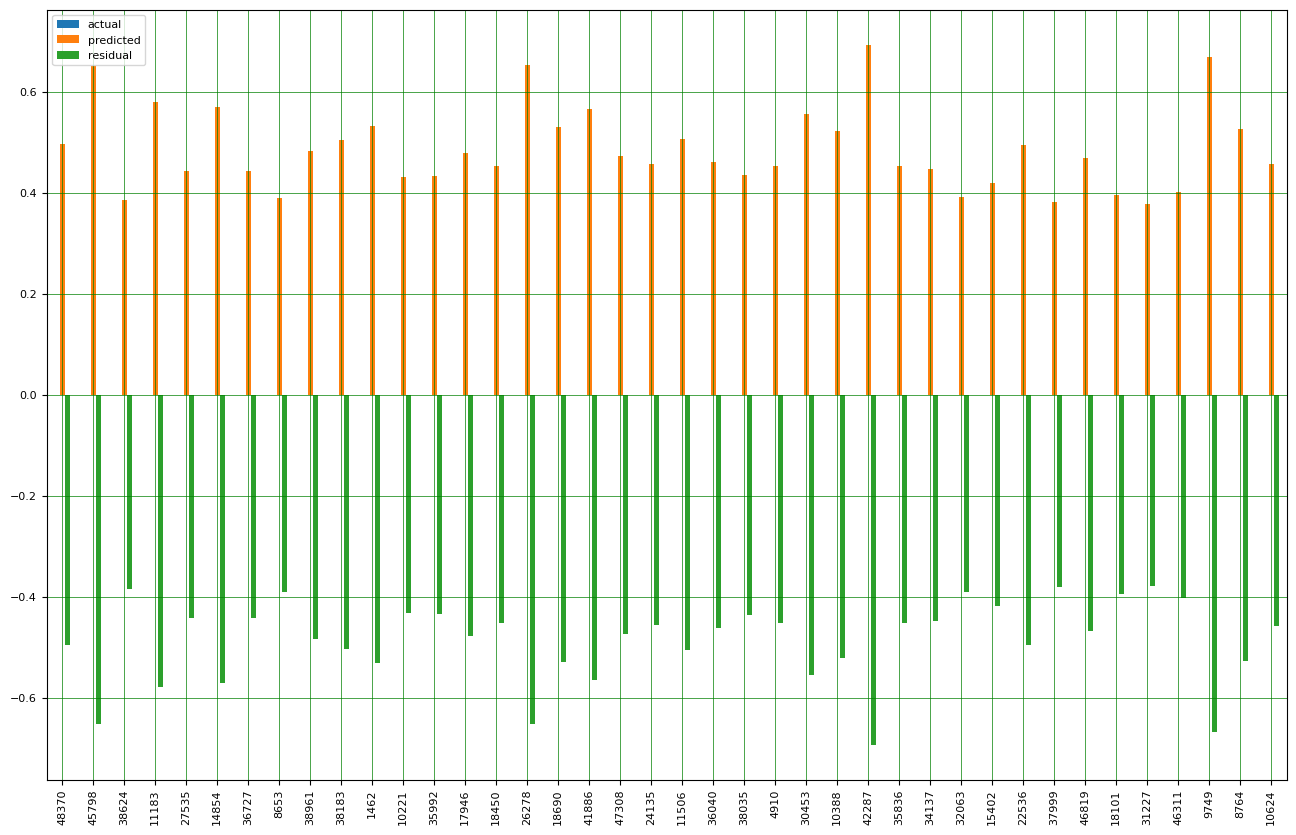

In [ ]:
df0m = residuals[residuals.actual == 0].sample(40)
df0m.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

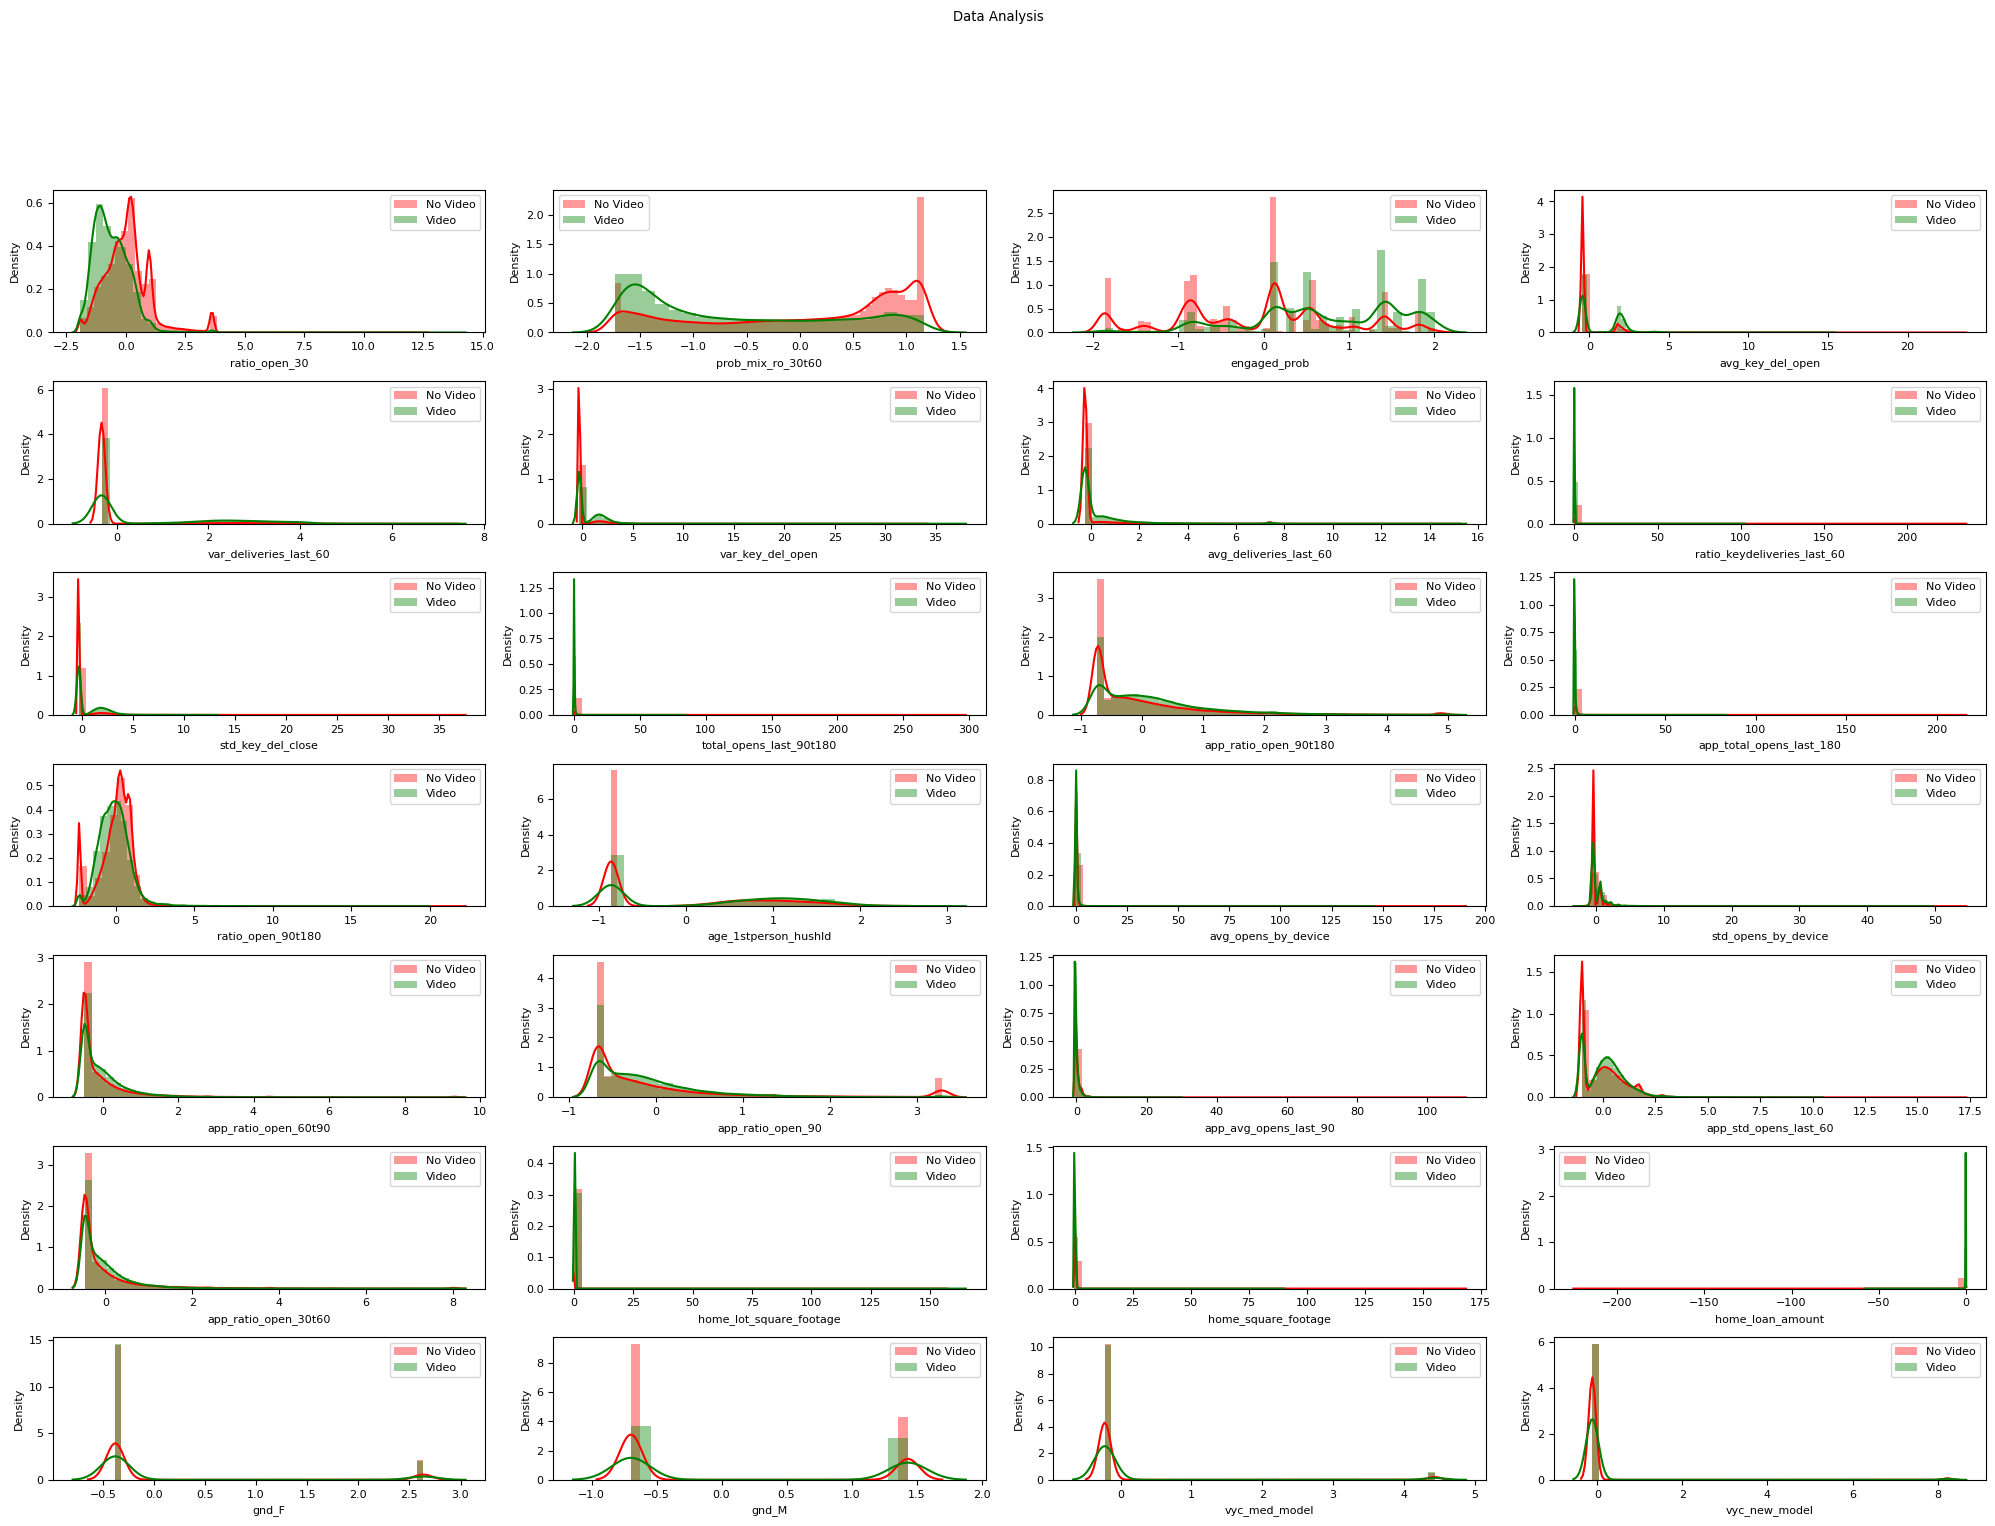

In [ ]:
fig = plt.figure(figsize = (20,60))
j = 0
for i in X_train.columns:
    
    plt.subplot(30, 4, j+1)
    j += 1
    sns.distplot(X_train[i][y_train==0], color='r', label = 'No Video')
    sns.distplot(X_train[i][y_train==1], color='g', label = 'Video')
    plt.legend(loc='best')
    
fig.suptitle('Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()